By [Kevin Michalewicz](https://kevinmichalewicz.com) on April 2023

This notebook details how to pre-process antibody structures to obtain aligned normal mode correlation maps. After that, training and evaluation using the ANTIPASTI model is explained.

In [1]:
# General imports
import cv2
import itertools
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.colors import CenteredNorm

# PyTorch-related libraries
from adabelief_pytorch import AdaBelief
from torch.optim import LBFGS
from torch.nn import MSELoss
from torchmetrics import PearsonCorrCoef

# ANTIPASTI
from antipasti.model.model import ANTIPASTI
from antipasti.preprocessing.preprocessing import Preprocessing
from antipasti.utils.explaining_utils import plot_map_with_regions
from antipasti.utils.torch_utils import create_test_set, save_checkpoint, training_routine

# Pre-processing

In [2]:
modes = 30 # Number of normal modes to consider. Relevant if renew_maps is True
renew_maps = False # True to compute again all the normal mode correlation maps
renew_residues = False # True to retrieve again all the chain lengths 
mode = 'fully-extended' # Choose between 'fully-extended' and 'fully-cropped'
regions = 'paired_hl' # 'paired_hl' or 'heavy'
#pathological = ['3etb', '3gkz', '3lrh', '3t0w', '3t0x', '3uze', '3uzq', '4f9l', '4gqp', '4k3h', '6d6t']
pathological = ['5omm', '1mj7', '1qfw', '1qyg', '3ifl', '3lrh', '3pp4', '3ru8', '3t0w', '3t0x', '4fqr', '4gxu', '4jfx', '4k3h', '4jfz', '4jg0', '4jg1', '4jn2', '4o4y', '4qxt', '4r3s', '4w6y', '4w6y', '5ies', '5ivn', '5j57', '5kvd', '5kzp', '5mes', '5nmv', '5sy8', '5t29', '5t5b', '5vag', '3etb', '3gkz', '3uze', '3uzq', '4f9l', '4gqp', '4r2g', '5c6t']
preprocessed_data = Preprocessing(modes=modes, regions=regions, pathological=pathological, renew_maps=renew_maps, renew_residues=renew_residues, mode=mode)

Let's plot some histograms to see the distributions of the chain lengths and the binding affinities.

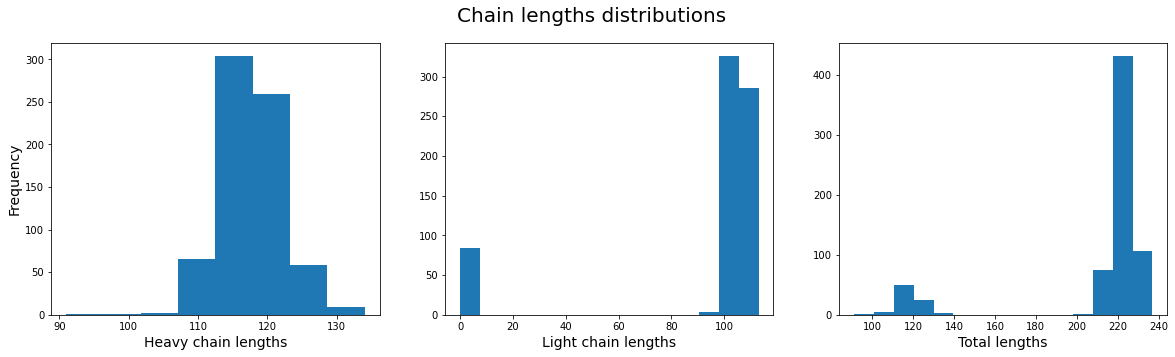

In [3]:
title_size = 20
font_size = 14

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Chain lengths distributions', size=title_size)
ax1.hist(preprocessed_data.heavy, 8)
ax2.hist(preprocessed_data.light, 15)
ax3.hist([sum(x) for x in zip(preprocessed_data.heavy, preprocessed_data.light)], 15)

# Changing plotting settings
ax1.set_ylabel('Frequency', size=font_size)
ax1.set_xlabel('Heavy chain lengths', size=font_size)
ax2.set_xlabel('Light chain lengths', size=font_size)
ax3.set_xlabel('Total lengths', size=font_size)

plt.show()

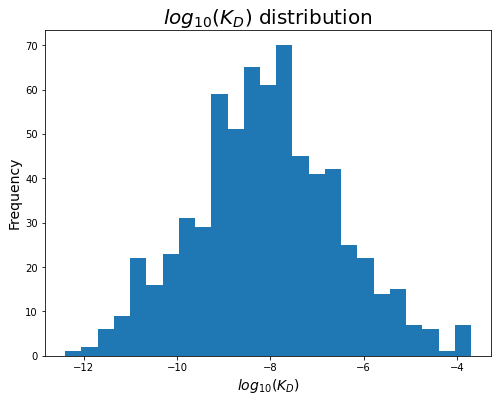

In [4]:
fig = plt.figure(figsize=(8, 6))
plt.title('$log_{10}(K_D)$ distribution', size=title_size)
plt.hist(preprocessed_data.train_y, 25)
plt.xlabel('$log_{10}(K_D)$', size=font_size)
plt.ylabel('Frequency', size=font_size)
plt.show()

A sample normal mode correlation map before and after adding the blank pixels.

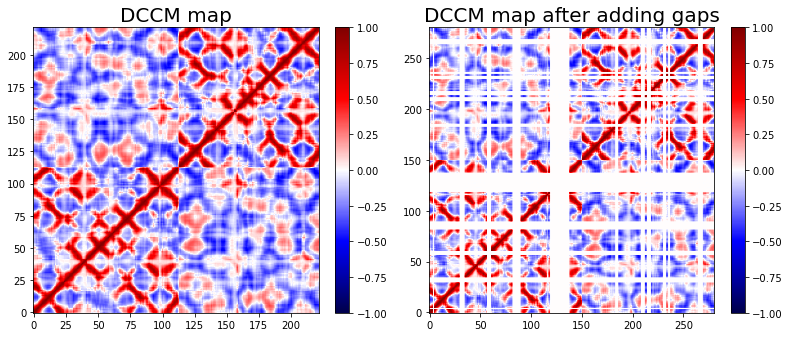

In [5]:
input_shape = preprocessed_data.train_x.shape[-1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5.25))
im1 = ax1.imshow(preprocessed_data.raw_imgs[74], origin='lower', cmap='seismic', norm=CenteredNorm())
im2 = ax2.imshow(preprocessed_data.train_x[74].reshape(input_shape, input_shape), origin='lower', cmap='seismic', norm=CenteredNorm())

ax1.set_title('DCCM map', size=title_size)
ax2.set_title('DCCM map after adding gaps', size=title_size)

plt.colorbar(im1, ax=ax1, fraction=0.045)
plt.colorbar(im2, ax=ax2, fraction=0.045)

ax1.tick_params(axis='both', which='major', labelsize=10)
ax2.tick_params(axis='both', which='major', labelsize=10)

plt.show()

In [6]:
# The test set is generated
train_x, test_x, train_y, test_y, idx_tr, idx_te = create_test_set(preprocessed_data.train_x, preprocessed_data.train_y)

In [172]:
# Hyperparameters
n_filters = 3
filter_size = 5
pooling_size = 2
learning_rate = 0.00027253018778843 * 2.5

# Defining the model, optimiser and loss function
model = ANTIPASTI(n_filters=n_filters, filter_size=filter_size, pooling_size=pooling_size, input_shape=input_shape)
criterion = MSELoss() #-PearsonCorrCoef()
#optimiser = LBFGS(model.parameters(), lr=1e-3, history_size=10)
optimiser = AdaBelief(model.parameters(), lr=learning_rate, eps=1e-8, print_change_log=False) 

print(model)

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief
ANTIPASTI(
  (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropit): Dropout(p=0.05, inplace=False)
  (relu): ReLU()
  (fc1): Linear(in_features=57132, out_features=1, bias=False)
)


In [173]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [174]:
#{'learning_rate': 0.00027253018778843, 'n_max_epochs': 65, 'pooling_size': 1, 'filter_size': 4, 'n_filters': 4}
#{'learning_rate': 0.0008657756272162166, 'n_max_epochs': 82, 'pooling_size': 1, 'filter_size': 5, 'n_filters': 1}. Best is trial 30 with value: 1.0617385705312092.

# Training

In [175]:
train_losses = []
test_losses = []

In [193]:
model.train()
n_max_epochs = 13 
max_corr = 0.87
batch_size = 32

train_loss, test_loss, inter_filter, y_test, output_test = training_routine(model, criterion, optimiser, train_x, test_x, train_y, test_y, n_max_epochs=n_max_epochs, max_corr=max_corr, batch_size=batch_size)

# Saving the losses
train_losses.extend(train_loss)
test_losses.extend(test_loss)

tensor(0.4721, grad_fn=<MulBackward0>)
tensor(0.4718, grad_fn=<MulBackward0>)
tensor(0.4717, grad_fn=<MulBackward0>)
tensor(0.4717, grad_fn=<MulBackward0>)
tensor(0.4719, grad_fn=<MulBackward0>)
tensor(0.4719, grad_fn=<MulBackward0>)
tensor(0.4717, grad_fn=<MulBackward0>)
tensor(0.4711, grad_fn=<MulBackward0>)
tensor(0.4709, grad_fn=<MulBackward0>)
tensor(0.4706, grad_fn=<MulBackward0>)
tensor(0.4696, grad_fn=<MulBackward0>)
tensor(0.4682, grad_fn=<MulBackward0>)
tensor(0.4674, grad_fn=<MulBackward0>)
tensor(0.4670, grad_fn=<MulBackward0>)
tensor(0.4665, grad_fn=<MulBackward0>)
tensor(0.4657, grad_fn=<MulBackward0>)
tensor(0.4648, grad_fn=<MulBackward0>)
tensor(0.4641, grad_fn=<MulBackward0>)
tensor(0.4633, grad_fn=<MulBackward0>)
tensor(0.4630, grad_fn=<MulBackward0>)
tensor(0.4629, grad_fn=<MulBackward0>)
tensor([[-8.1063]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.0694]], grad_fn=<MmBackward0>)
tensor([[-7.6990]])
------------------------
tenso

tensor(0.4343, grad_fn=<MulBackward0>)
tensor(0.4334, grad_fn=<MulBackward0>)
tensor(0.4328, grad_fn=<MulBackward0>)
tensor(0.4325, grad_fn=<MulBackward0>)
tensor(0.4323, grad_fn=<MulBackward0>)
tensor(0.4320, grad_fn=<MulBackward0>)
tensor(0.4313, grad_fn=<MulBackward0>)
tensor(0.4306, grad_fn=<MulBackward0>)
tensor(0.4299, grad_fn=<MulBackward0>)
tensor(0.4294, grad_fn=<MulBackward0>)
tensor(0.4292, grad_fn=<MulBackward0>)
tensor(0.4289, grad_fn=<MulBackward0>)
tensor(0.4286, grad_fn=<MulBackward0>)
tensor(0.4281, grad_fn=<MulBackward0>)
tensor(0.4277, grad_fn=<MulBackward0>)
tensor(0.4273, grad_fn=<MulBackward0>)
tensor(0.4269, grad_fn=<MulBackward0>)
tensor(0.4264, grad_fn=<MulBackward0>)
tensor(0.4259, grad_fn=<MulBackward0>)
tensor(0.4255, grad_fn=<MulBackward0>)
tensor([[-7.6704]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-6.9693]], grad_fn=<MmBackward0>)
tensor([[-7.6990]])
------------------------
tensor([[-6.7828]], grad_fn=<MmBackward0>)
t

tensor(0.4007, grad_fn=<MulBackward0>)
tensor(0.4010, grad_fn=<MulBackward0>)
tensor(0.4006, grad_fn=<MulBackward0>)
tensor(0.4000, grad_fn=<MulBackward0>)
tensor(0.4003, grad_fn=<MulBackward0>)
tensor(0.4015, grad_fn=<MulBackward0>)
tensor(0.4023, grad_fn=<MulBackward0>)
tensor(0.4025, grad_fn=<MulBackward0>)
tensor(0.4017, grad_fn=<MulBackward0>)
tensor(0.4006, grad_fn=<MulBackward0>)
tensor(0.3997, grad_fn=<MulBackward0>)
tensor(0.3992, grad_fn=<MulBackward0>)
tensor(0.3991, grad_fn=<MulBackward0>)
tensor(0.3992, grad_fn=<MulBackward0>)
tensor(0.3990, grad_fn=<MulBackward0>)
tensor(0.3982, grad_fn=<MulBackward0>)
tensor(0.3974, grad_fn=<MulBackward0>)
tensor(0.3965, grad_fn=<MulBackward0>)
tensor(0.3958, grad_fn=<MulBackward0>)
tensor(0.3954, grad_fn=<MulBackward0>)
tensor([[-7.9702]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.0055]], grad_fn=<MmBackward0>)
tensor([[-7.6990]])
------------------------
tensor([[-7.0572]], grad_fn=<MmBackward0>)
t

tensor(0.3779, grad_fn=<MulBackward0>)
tensor(0.3781, grad_fn=<MulBackward0>)
tensor(0.3781, grad_fn=<MulBackward0>)
tensor(0.3778, grad_fn=<MulBackward0>)
tensor(0.3773, grad_fn=<MulBackward0>)
tensor(0.3769, grad_fn=<MulBackward0>)
tensor(0.3776, grad_fn=<MulBackward0>)
tensor(0.3786, grad_fn=<MulBackward0>)
tensor(0.3797, grad_fn=<MulBackward0>)
tensor(0.3800, grad_fn=<MulBackward0>)
tensor(0.3792, grad_fn=<MulBackward0>)
tensor(0.3781, grad_fn=<MulBackward0>)
tensor(0.3772, grad_fn=<MulBackward0>)
tensor(0.3768, grad_fn=<MulBackward0>)
tensor(0.3766, grad_fn=<MulBackward0>)
tensor(0.3763, grad_fn=<MulBackward0>)
tensor(0.3757, grad_fn=<MulBackward0>)
tensor(0.3752, grad_fn=<MulBackward0>)
tensor(0.3748, grad_fn=<MulBackward0>)
tensor(0.3748, grad_fn=<MulBackward0>)
tensor(0.3747, grad_fn=<MulBackward0>)
tensor([[-8.0631]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-6.9494]], grad_fn=<MmBackward0>)
tensor([[-7.6990]])
------------------------
tenso

In [184]:
#optimiser.param_groups[0]['lr'] = 2e-4

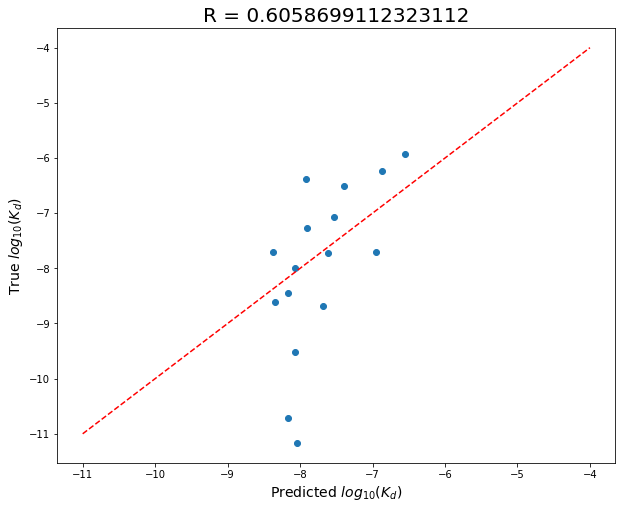

In [185]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(np.array(output_test), y_test[:,0].detach().numpy())
corr = np.corrcoef(np.array(output_test).T, y_test[:,0].detach().numpy().T)[1,0]
plt.plot([-11,-4],[-11,-4], c='r', linestyle='dashed')
plt.title('R = '+str(corr), size=title_size)
plt.xlabel('Predicted $log_{10}$($K_d$)', size=font_size)
plt.ylabel('True $log_{10}$($K_d$)', size=font_size)
plt.show()

Total image is product of this image
Total image is product of this image
Total image is product of this image


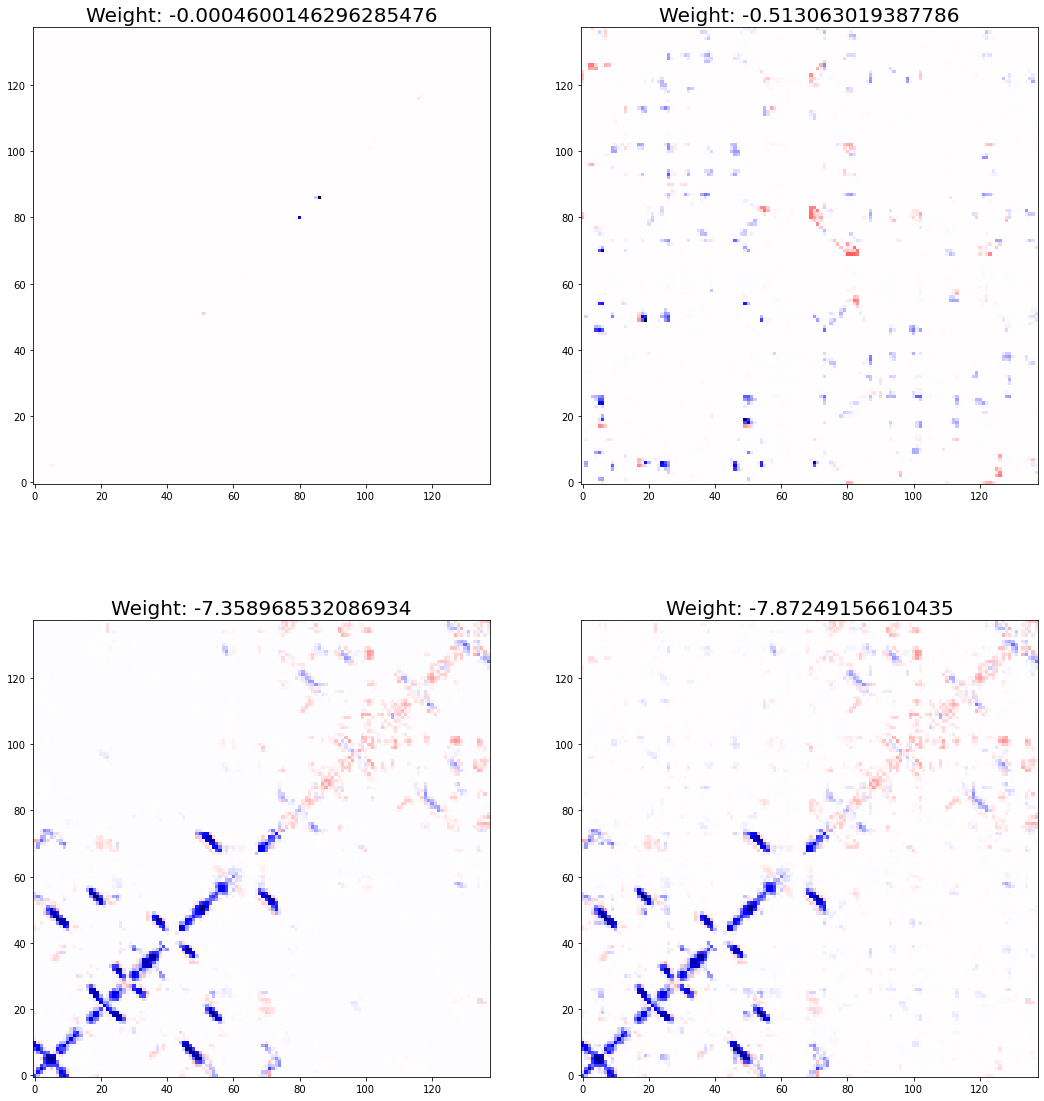

In [186]:
fig, axs = plt.subplots((n_filters+1)//2, 2, figsize=(18, 20))
size_le = int(np.sqrt(model.fc1.weight.data.numpy().shape[-1] / n_filters))
learnt_filter = np.zeros((size_le, size_le))

for i, j in itertools.product(range((n_filters+1)//2), range(2)):
    if j == 1 and i == (n_filters+1)//2-1 and n_filters % 2 != 0:
        im_ = learnt_filter
    else:
        print('Total image is product of this image')
        im_ = np.multiply(np.mean(inter_filter, axis=0)[2*i+j], model.fc1.weight.data.numpy().reshape(n_filters,size_le**2)[2*i+j].reshape(size_le, size_le))
        learnt_filter += im_
    im = axs[i,j].imshow(im_, origin='lower', cmap='seismic', norm=CenteredNorm())
    axs[i,j].set_title('Weight: '+str(im_.sum()), size=title_size)

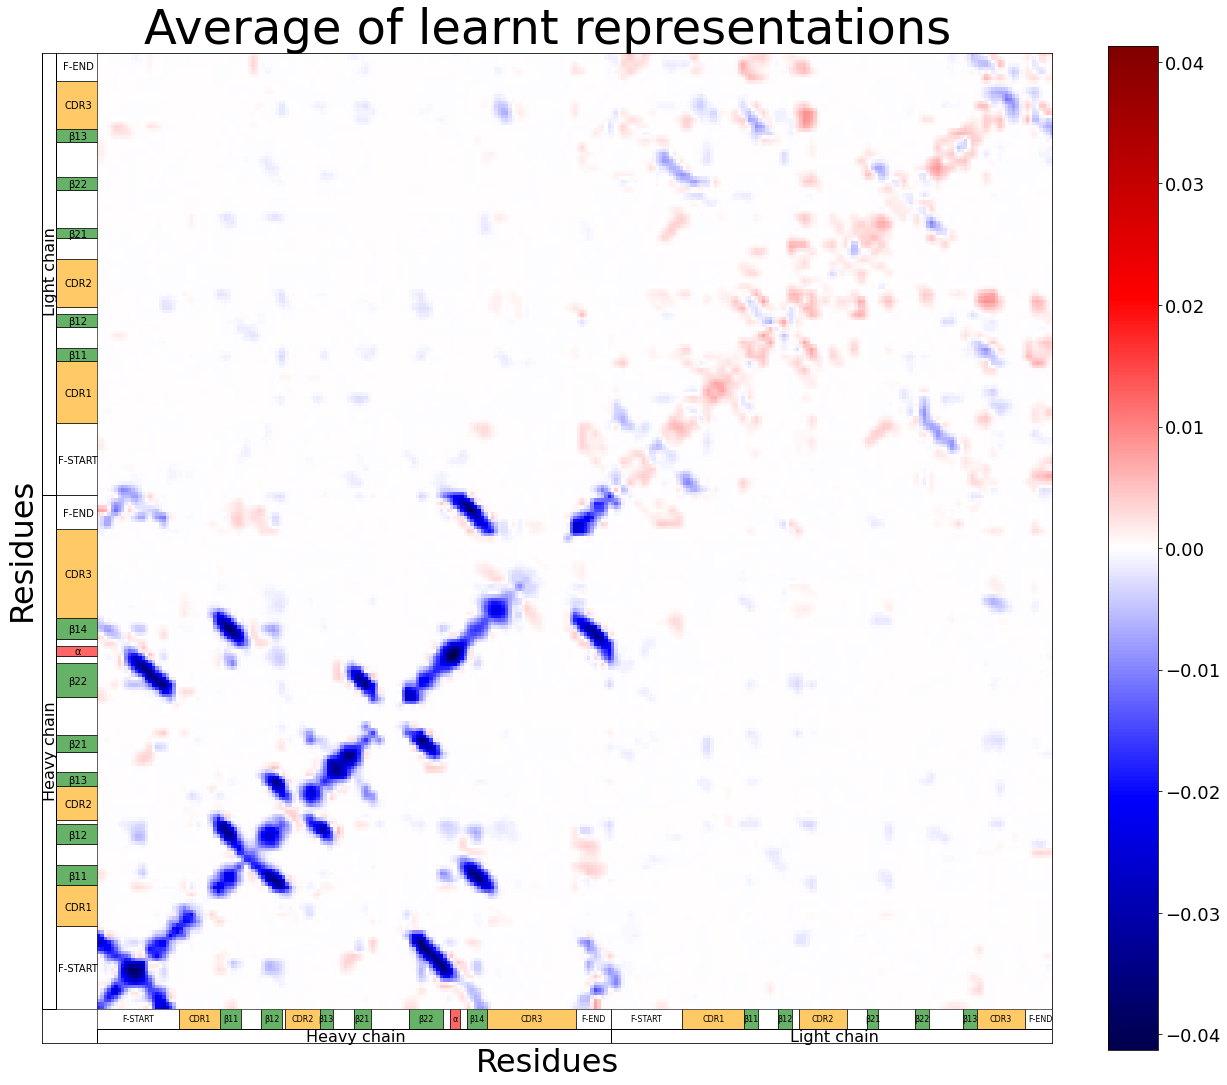

In [187]:
plot_map_with_regions(preprocessed_data, cv2.resize(learnt_filter, dsize=(train_x.shape[2], train_x.shape[2])), 'Average of learnt representations')

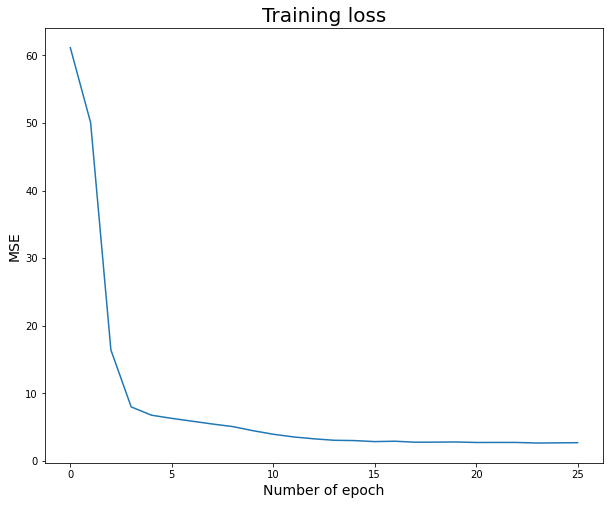

In [188]:
fig = plt.figure(figsize=(10, 8))
plt.plot([train_losses[i] for i in range(len(train_losses))])
plt.title('Training loss', size=title_size)
plt.xlabel('Number of epoch', size=font_size)
plt.ylabel('MSE', size=font_size)
plt.show()

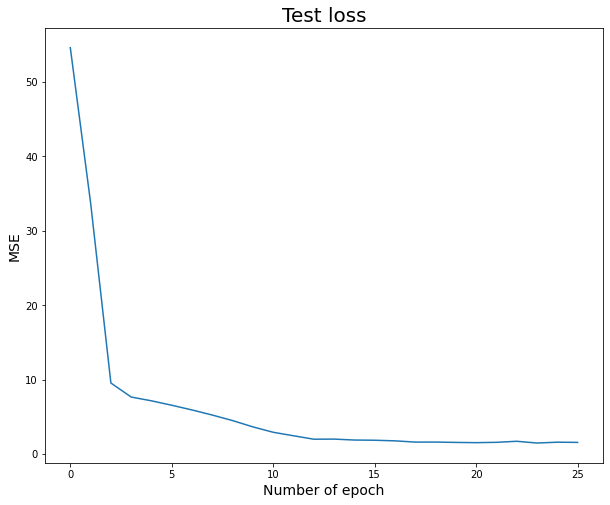

In [189]:
fig = plt.figure(figsize=(10, 8))
plt.plot([test_losses[i] for i in range(len(test_losses))])
plt.title('Test loss', size=title_size)
plt.xlabel('Number of epoch', size=font_size)
plt.ylabel('MSE', size=font_size)
plt.show()

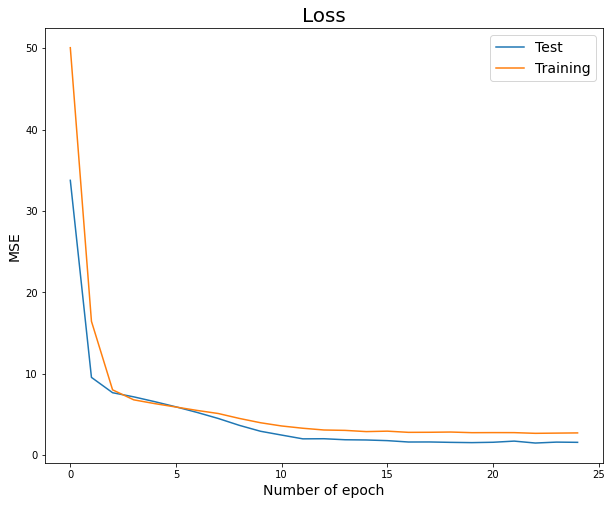

In [190]:
fig = plt.figure(figsize=(10, 8))
plt.plot([test_losses[1:][i] for i in range(len(test_losses[1:]))])
plt.plot([train_losses[1:][i] for i in range(len(train_losses[1:]))])
plt.title('Loss', size=title_size)
plt.xlabel('Number of epoch', size=font_size)
plt.ylabel('MSE', size=font_size)
plt.legend(['Test', 'Training'], prop={'size': font_size})
plt.show()

In [191]:
model(train_x[40:80])[0]

tensor([[-7.0329],
        [-7.8497],
        [-7.3129],
        [-8.6570],
        [-7.2091],
        [-6.8962],
        [-7.0026],
        [-7.8558],
        [-7.8817],
        [-8.0159],
        [-7.7053],
        [-7.8087],
        [-7.8842],
        [-7.7886],
        [-7.6200],
        [-9.1190],
        [-8.0298],
        [-8.0658],
        [-8.0145],
        [-7.6475],
        [-6.7052],
        [-7.8269],
        [-7.8157],
        [-8.0438],
        [-6.4644],
        [-6.8832],
        [-6.8611],
        [-7.5468],
        [-8.4645],
        [-7.9871],
        [-5.8670],
        [-8.1564],
        [-8.0312],
        [-7.9896],
        [-8.4379],
        [-7.9782],
        [-7.9011],
        [-8.3914],
        [-8.8326],
        [-8.2680]], grad_fn=<MmBackward0>)

In [192]:
train_y[40:80]

tensor([[ -7.4318],
        [ -8.4559],
        [ -6.6289],
        [ -7.6021],
        [ -5.3979],
        [ -5.0410],
        [ -5.3098],
        [ -9.2147],
        [ -8.7375],
        [ -7.0410],
        [ -8.0410],
        [ -8.8861],
        [ -5.7077],
        [ -4.0414],
        [ -5.9747],
        [ -8.0809],
        [ -7.6840],
        [ -8.7959],
        [ -7.8539],
        [-10.0000],
        [ -7.6990],
        [ -9.6990],
        [ -9.1549],
        [-10.0088],
        [-10.3979],
        [ -5.3979],
        [ -6.8539],
        [ -8.5229],
        [ -8.5376],
        [ -6.6198],
        [ -4.6198],
        [ -5.5638],
        [ -6.0809],
        [ -8.7447],
        [ -8.0000],
        [ -5.7959],
        [ -4.9586],
        [ -8.4318],
        [ -7.8539],
        [ -7.8013]])

In [154]:
##### Uncomment the following lines to save a checkpoint

path = '../checkpoints/model_' + regions + '_epochs_' + str(len(train_losses)) + '_modes_' + str(modes) + '_pool_' + str(pooling_size) + '_filters_' + str(n_filters) + '_size_' + str(filter_size) + '.pt'
save_checkpoint(path, model, optimiser, train_losses, test_losses)
np.save('../checkpoints/learnt_filter_'+regions+'_epochs_'+str(len(train_losses))+'_modes_'+str(modes)+'_pool_'+str(pooling_size)+'_filters_'+str(n_filters)+'_size_'+str(filter_size)+'.npy', learnt_filter)

In [11]:
##### Uncomment the following lines to load a checkpoint

from antipasti.utils.torch_utils import load_checkpoint
#
nf_chckpt = 2
pool_chckpt = 1
k_chckpt = 4
ep_chckpt = 336

path = '../checkpoints/model_' + regions + '_epochs_' + str(ep_chckpt) + '_modes_' + str(modes) + '_pool_' + str(pool_chckpt) + '_filters_' + str(nf_chckpt) + '_size_' + str(k_chckpt) + '.pt'
model,optimiser,_,train_losses, test_losses = load_checkpoint(path, input_shape)

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief
